# **4th Delivery Massive Graph Management and Analytics**

Let's begin this notebook by loading some packages.


In [1]:
!pip install scipy networkx -U scikit-learn tqdm gensim
!pip install numpy==1.24.4
!pip install python-igraph
!pip uninstall matplotlib
!pip install matplotlib==3.4.3
!pip install cairocffi
!pip install ndlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 84.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.3 MB/s eta 0:00:00
Found existing installation: matplotlib 3.7.1
Uninstalling matplotlib-3.7.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/matplotlib-3.7.1-py3.10-nspkg.pth
    /usr/local/lib/python3.10/dist-packages/matplotlib-3.7.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/matplotlib/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.10/dist-packages/pylab.py
Proceed (Y/n)? Y
  Successfully uninstalled matplotlib-3.7.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 33.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.4.3-cp310-cp310-linux_x86_64.whl size=10439856 sha256=be9b9b63a62aed18c97a4128c92ff60f6b8d5c22e5f088d4bd68a772db261d7a
  St

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.2/110.2 kB 2.8 MB/s eta 0:00:00


In [3]:
!unzip /content/fourth_delivery.zip

Archive:  /content/fourth_delivery.zip
   creating: fourth_delivery/.ipynb_checkpoints/
  inflating: fourth_delivery/.ipynb_checkpoints/CommunityDetection_Ingrid_Daniel_vf-checkpoint.ipynb  
  inflating: fourth_delivery/CommunityDetection_Ingrid_Daniel_vf.ipynb  
   creating: fourth_delivery/data/
  inflating: fourth_delivery/data/CA-HepTh.txt  
  inflating: fourth_delivery/data/com-amazon.all.dedup.cmty.txt.gz  
  inflating: fourth_delivery/data/com-amazon.ungraph.txt  
  inflating: fourth_delivery/data/example_graph.txt  
  inflating: fourth_delivery/data/example_groundtruth.txt  
  inflating: fourth_delivery/data/facebook_combined.txt  
   creating: fourth_delivery/DeepIM/
   creating: fourth_delivery/DeepIM/data/
  inflating: fourth_delivery/DeepIM/data/jazz_mean_IC10.SG  
  inflating: fourth_delivery/DeepIM/data/jazz_mean_IC100.SG  
  inflating: fourth_delivery/DeepIM/data/jazz_mean_IC200.SG  
  inflating: fourth_delivery/DeepIM/data/jazz_mean_IC50.SG  
  inflating: fourth_deliver

In [6]:
%matplotlib inline
import numpy as np
import scipy
import matplotlib.pyplot as plt
import networkx as nx
import numpy.linalg
import scipy.sparse as sp
from bisect import bisect_left
import igraph
from random import uniform, seed
import time
from igraph import *
from tqdm import tqdm
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import copy
import random
import pickle
from scipy.special import softmax
from scipy.sparse import csr_matrix
from PIL import Image
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

from DeepIM.main.utils import load_dataset, InverseProblemDataset, adj_process, diffusion_evaluation
from DeepIM.main.model.gat import GAT, SpGAT
from DeepIM.main.model.model import GNNModel, VAEModel, DiffusionPropagate, Encoder, Decoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable

/content/DeepIM/main/model/model.py:39: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if drop_prob is 0:


# Comparison of Community Detection Methods

Community detection is a fundamental task in network analysis, aiming to identify groups of nodes that are densely connected within themselves but sparsely connected to nodes in other groups. In this Colab notebook, we explore various community detection methods.

## Load an example graph

In [7]:
from multiloccom import load_graph, extract_subgraph
from multiloccom import approximate_ppr, conductance_sweep_cut
from multiloccom import multicom
from multiloccom import load_groundtruth, compute_f1_scores
from multiloccom import plot_nx_clusters

In [8]:
# Synthetic data

print("Load synthetic data...")
adj_matrix = load_graph("/content/data/example_graph.txt")
groundtruth = load_groundtruth("/content/data/example_groundtruth.txt")

Load synthetic data...


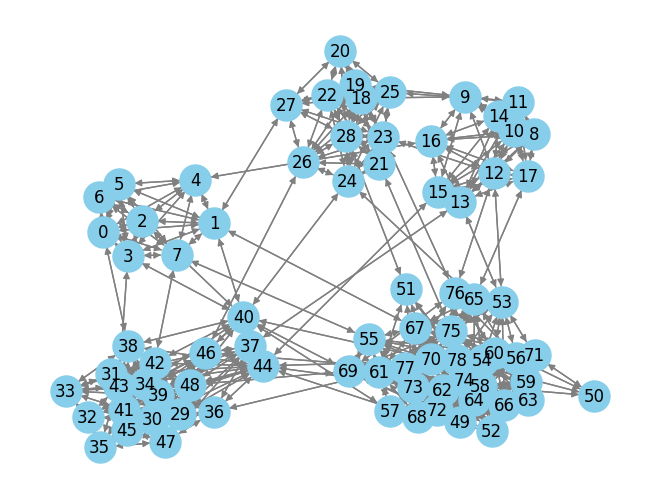

In [9]:
# Plot the graph
G = nx.DiGraph(adj_matrix)

nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')

# Show the plot
plt.show()

## SNAP datasets: Amazon product co-purchasing network and ground-truth communities

Network was collected by crawling Amazon website. It is based on Customers Who Bought This Item Also Bought feature of the Amazon website. If a product i is frequently co-purchased with product j, the graph contains an undirected edge from i to j. Each product category provided by Amazon defines each ground-truth community.

Data available on: https://snap.stanford.edu/data/com-Amazon.html

- The average clustering coefficient: $0.3967$.
- The 90-percentile effective diameter:	$15$.

In [10]:
print("Load Amazon data...")
adj_matrix_snap = load_graph("/content/data/com-amazon.ungraph.txt")
groundtruth_snap = load_groundtruth("/content/data/com-amazon.all.dedup.cmty.txt.gz")

Load Amazon data...


## Greedy Approach

### Louvain's Method [1]

The proposed method is based on modularity optimization, aiming to identify sets of densely interconnected nodes within the network. Unlike other community detection algorithms, the Louvain's method demonstrates superior computational efficiency while maintaining high-quality community detection, as assessed by the modularity metric.

The approach involves two iterative phases: initially assigning each node to its own community and then iteratively optimizing the modularity by moving nodes between communities based on the gain in modularity. This iterative process continues until no further improvement can be achieved. The method's efficiency stems from its ability to compute modularity gain efficiently, particularly during the initial iterations when the number of communities decreases rapidly. Additionally, the method incorporates a hierarchical aspect, revealing communities of communities through successive iterations.

Louvain's method runs in $O(nᆞlog^2n)$ time, where n is the number of nodes in the graph.

Obs.: A graph is said to be modular if it has a high density of intra-community edges and a low density of inter-community edges.

For a **synthetic dataset**:

In [11]:
!pip install communities

  Preparing metadata (setup.py) ... done
  Created wheel for communities: filename=communities-3.0.0-py3-none-any.whl size=18280 sha256=e1777b5b807ec5e8199e82a969b900f5b617652f19f17b8c6a39b94867cece36
  Stored in directory: /root/.cache/pip/wheels/13/d1/50/1cad389ce48bafd3d8e08060738391d303a53b6a2b6857db94
Successfully built communities


In [12]:
import numpy as np
from communities.algorithms import louvain_method

adj_matrix = load_graph("/content/data/example_graph.txt")

dense_array = adj_matrix.toarray()
dense_array = np.array(dense_array)

communities, _ = louvain_method(dense_array)

In [13]:
print(communities)

[{0, 1, 2, 3, 4, 5, 6, 7}, {8, 9, 10, 11, 12, 13, 14, 15, 16, 17}, {18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}, {29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48}, {49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78}]


#### Modularity


The modularity tells us about the strength of division of a network or graph into communities. It essentially measures how well the network is divided based on the connectivity patterns between nodes.

Here's a breakdown of what a high modularity value indicates:

- Dense connections within communities: Nodes within the same community tend to have many connections (edges) with each other, suggesting strong relationships or interactions.
-Sparse connections between communities: Nodes in different communities have fewer connections compared to those within the same community. This implies that the communities are distinct and not heavily interconnected.

Therefore, a higher modularity value generally signifies a clearer and more meaningful community structure in the network. It suggests that the identified communities likely represent groups of nodes that are more closely related or interconnected compared to nodes in other groups.

In [14]:
from communities.utilities import modularity_matrix, modularity

mod_matrix = modularity_matrix(dense_array)
Q = modularity(mod_matrix, communities)
print(Q)

0.3267732776820597


A modularity of 0.33 indicates a moderately ***strong community structure*** in the network analyzed.

#### Visualization

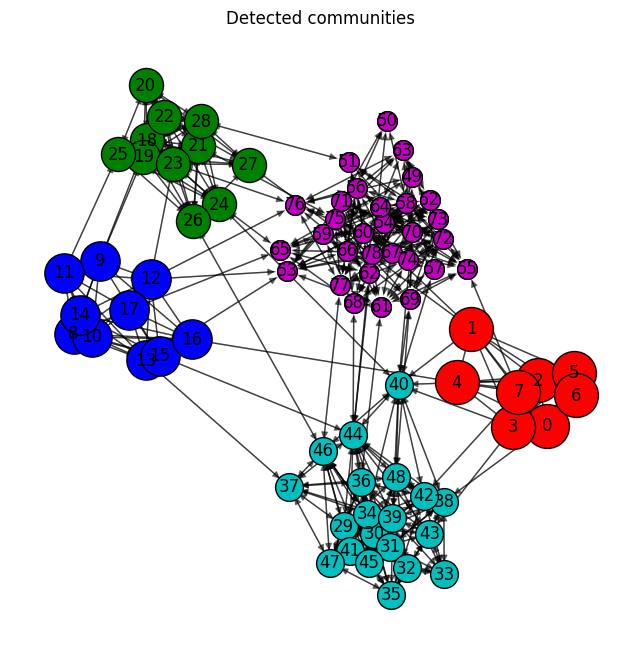

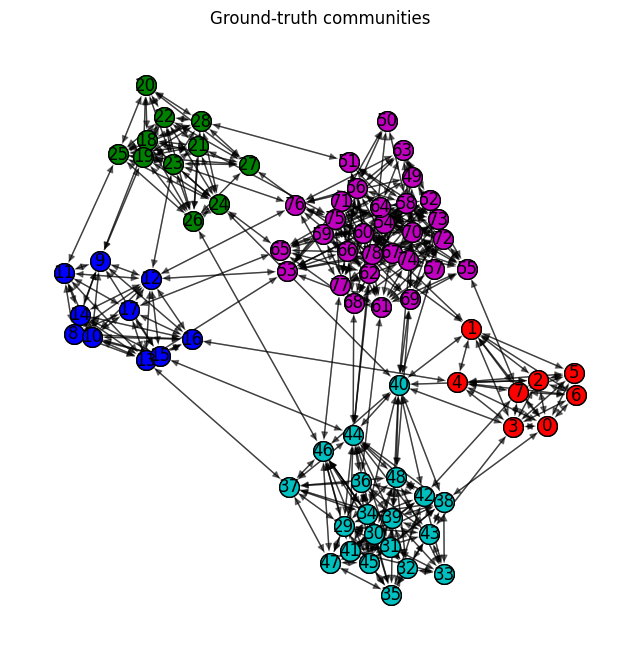

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph(adj_matrix)
pos = nx.fruchterman_reingold_layout(G)

plot_nx_clusters(G, communities, pos, "Detected communities", plot_overlaps=True)

plot_nx_clusters(G, groundtruth, pos, "Ground-truth communities")


For a **real-world dataset**:

In [ ]:
adj_matrix_snap = load_graph("/content/data/com-amazon.ungraph.txt")

dense_array_snap = adj_matrix_snap.toarray()
dense_array_snap = np.array(dense_array_snap)

communities_snap, _ = louvain_method(dense_array_snap)

We can observe that the Louvain's method is not ideal for large datasets since it relies on an iterative optimization process that involves optimizing a quality function to maximize the modularity of the graph partition. This optimization process can become computationally expensive for large datasets due to the need to evaluate the quality function and update the community structure iteratively. As the size of the dataset increases, the number of nodes and edges in the graph grows, leading to longer execution times and increased memory usage.

## Heuristics Approach

### Girvan-Newman algorithm [2]

This algorithm iteratively removes edges to create more connected components. Each component is considered a community, and the algorithm stops removing edges when no more gains in modularity can be made. Edges with the highest betweenness centralities (i.e. those that lie between many pairs of nodes) are removed. Formally, edge betweenness centrality is defined as:


$c_B(e) = \sum_{i,j}\frac{\sigma(i,j|e)}{\sigma(i,j)}$

where

- $\sigma(i,j)$ is the number of shortest paths from node $i$ to $j$.

- $\sigma(i,j|e)$ is the number of shortest paths that pass through edge $e$.

The Girvan-Newman algorithm runs in $O(m^2n)$ time, where m is the number of edges in the graph and n is the number of nodes.

For a **synthetic dataset**:

In [ ]:
from communities.algorithms import girvan_newman

adj_matrix = load_graph("/content/data/example_graph.txt")

dense_array = adj_matrix.toarray()
dense_array = np.array(dense_array)

communities_gn, _ = girvan_newman(dense_array)

In [ ]:
print(communities_gn)

[{0, 1, 2, 3, 4, 5, 6, 7}, {8, 9, 10, 11, 12, 13, 14, 15, 16, 17}, {18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}, {29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48}, {49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78}]


#### Modularity

In [ ]:
from communities.utilities import modularity_matrix, modularity

mod_matrix_gn = modularity_matrix(dense_array)
Q = modularity(mod_matrix_gn, communities_gn)
print(Q)

0.3267732776820597


The modularity observed for the heuristics approach is the same as the one observed for the greedy approach, indicating that both of them generated a ***strong community structure*** in the network analyzed.

#### Visualization

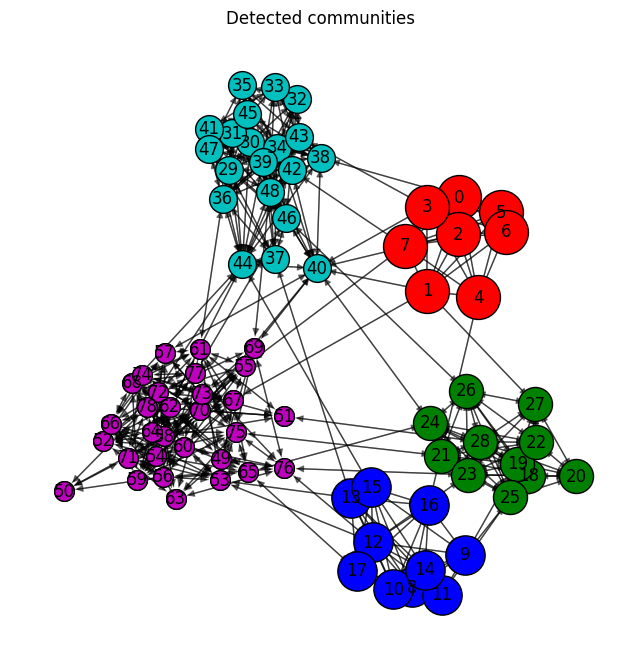

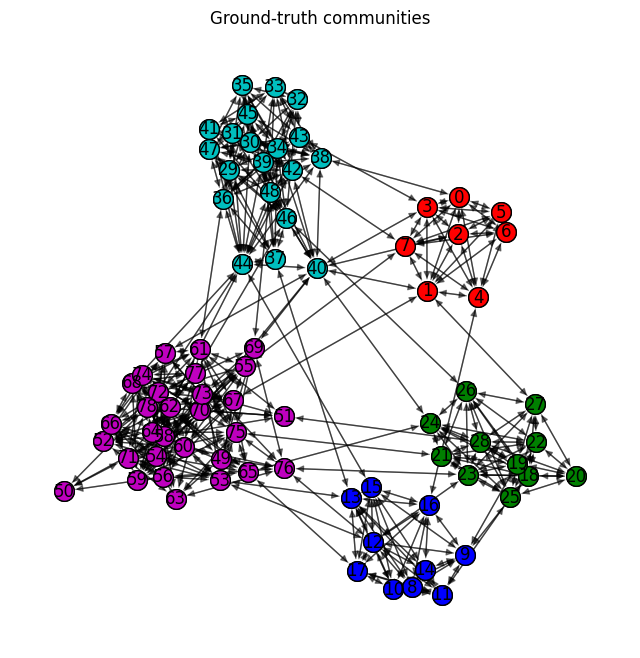

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph(adj_matrix)
pos = nx.fruchterman_reingold_layout(G)

plot_nx_clusters(G, communities_gn, pos, "Detected communities", plot_overlaps=True)

plot_nx_clusters(G, groundtruth, pos, "Ground-truth communities")


For a **real-world dataset**:

In [ ]:
adj_matrix_snap = load_graph("/content/data/com-amazon.ungraph.txt")

dense_array_snap = adj_matrix_snap.toarray()
dense_array_snap = np.array(dense_array_snap)

communities_snap_gn, _ = girvan_newman(dense_array_snap)

We can observe that the Girvan-Newman algorithm is not ideal for large datasets since it has a high computational complexity, particularly when dealing with large graphs. The algorithm involves recursively removing edges from the original graph and calculating metrics such as edge betweenness centrality, which can be computationally expensive, especially as the size of the dataset increases.

## ML Approach

### Multiple Local Community Detection [3]

The MULTICOM algorithm, introduced by Alexandre Hollocou et al., is a novel approach to community detection that leverages multiple local community detection techniques. Unlike traditional methods that focus on finding non-overlapping communities, MULTICOM is capable of identifying overlapping and hierarchical community structures within complex networks.

The key steps of the MULTICOM algorithm include:

1. Initialization: MULTICOM starts by selecting seed nodes within the network. These seed nodes serve as starting points for community detection.

2. Local Community Detection: For each seed node, MULTICOM applies local community detection algorithms to identify communities centered around that node. These algorithms may include techniques like approximate personalized PageRank (PPR) and conductance-based cuts.

3. Community Fusion: Once local communities are detected around each seed node, MULTICOM combines these communities to form a comprehensive set of overlapping and hierarchical communities within the network. This fusion process involves merging overlapping communities and identifying hierarchical relationships between them.

4. Evaluation: Finally, MULTICOM evaluates the quality of the detected communities using metrics such as F1-score, which measures the agreement between detected communities and ground truth communities in labeled datasets.

We apply the MULTICOM algorithm to a **synthetic dataset**, starting with a seed node and then evaluating the detected communities using F1-scores. Visualization techniques are employed to compare the detected communities with the ground truth.

In [ ]:
print("Apply MULTICOM on seed node 0")
seeds, communities_ml = multicom(adj_matrix, 0, approximate_ppr, conductance_sweep_cut, explored_ratio=.9)

print("Compute F1-scores for detected communities")
f1_scores = compute_f1_scores(communities_ml, groundtruth)
print (f1_scores)

Apply MULTICOM on seed node 0
Number of iterations 5
Compute F1-scores for detected communities
[1.0, 1.0, 0.9743589743589743, 1.0, 1.0]


#### Modularity

In [ ]:
from communities.utilities import modularity_matrix, modularity

dense_array = adj_matrix.toarray()
dense_array = np.array(dense_array)

mod_matrix_ml = modularity_matrix(dense_array)
Q = modularity(mod_matrix_ml, communities_ml)
print(Q)

NameError: name 'adj_matrix' is not defined

The modularity is a little lower than the ones of the previous methods, but it still indicates a **strong community structure**.

#### Visualization

Apply MULTICOM on seed node 0
Number of iterations 5
Compute F1-scores for detected communities
[1.0, 1.0, 0.9743589743589743, 1.0, 1.0]


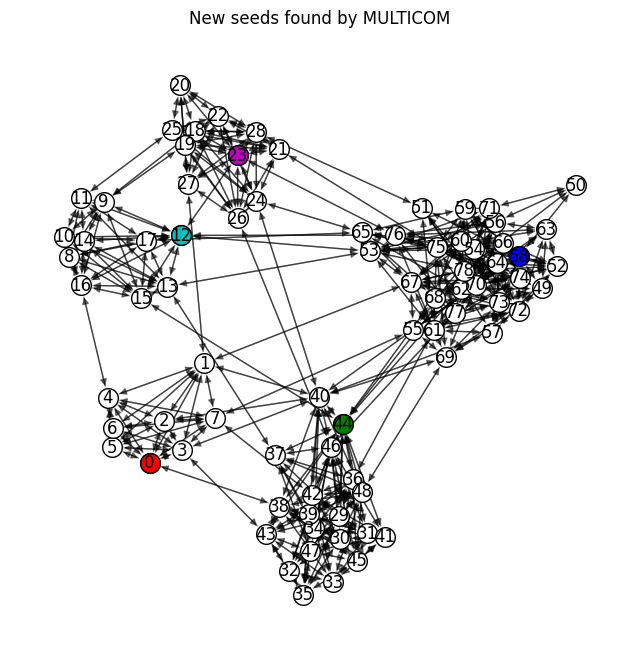

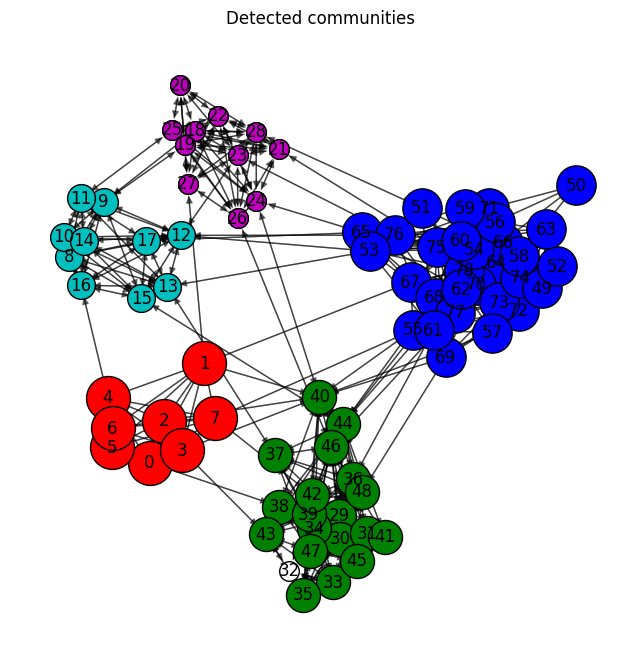

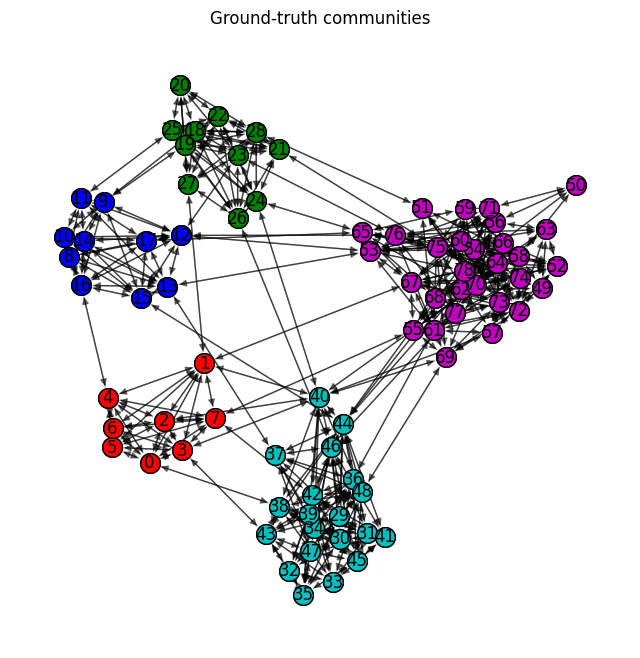

In [ ]:
G = nx.DiGraph(adj_matrix)
pos = nx.fruchterman_reingold_layout(G)

plot_nx_clusters(G, [[seed] for seed in seeds], pos, "New seeds found by MULTICOM")
plot_nx_clusters(G, communities_ml, pos, "Detected communities",plot_overlaps=True)
plot_nx_clusters(G, groundtruth, pos, "Ground-truth communities")

The MULTICOM algorithm iterated 5 times to detect communities around the seed node. The F1-scores for the detected communities are as follows: [$1.0$, $1.0$, $0.97$, $1.0$, $1.0$]. These scores indicate the agreement between the detected communities and the ground truth communities. A score of $1.0$ represents a perfect match, while lower scores indicate less agreement.

Next, we apply the MULTICOM algorithm to a **real-world dataset** obtained from the SNAP repository, specifically the Amazon product co-purchasing network. After preprocessing the data and filtering out nodes with zero degree, we apply MULTICOM and evaluate its performance on this dataset.

In [ ]:
print("Filter the nodes with degree 0")
degree = np.array(np.sum(adj_matrix_snap, axis=0))[0]
new_adj_matrix, new_groundtruth, node_map = extract_subgraph(adj_matrix_snap, groundtruth_snap, np.where(degree > 0)[0])

print("Apply MULTICOM on seed node 0")
scoring = lambda adj_matrix_snap, seed_set: approximate_ppr(adj_matrix_snap, seed_set, alpha=0.5, epsilon=1e-3)
seeds, communities_snap_ml = multicom(new_adj_matrix, 0, approximate_ppr, conductance_sweep_cut, explored_ratio=.9)

print("Compute the average F1-Score for detected communities")
print(np.mean(compute_f1_scores(communities_snap_ml, new_groundtruth)))

Filter the nodes with degree 0
Apply MULTICOM on seed node 0
Number of iterations 6
Compute the average F1-Score for detected communities
0.3679321427076907


The MULTICOM algorithm iterated 6 times to detect communities around the seed node. The average F1-score for the detected communities is $0.37$. This score represents the overall agreement between the detected communities and the ground truth communities in the real-world dataset. A lower score compared to the synthetic dataset suggests that the community structure in real-world datasets may be more complex or less accurately represented by the algorithm.

# Comparison of Influence Maximization Methods

Influence Maximization (IM) is the process of choosing a set of seeds from a social network so that the spred of influence is maximized, i.e. the most individuals will be influenced by the seed set.

Given $G(V,E)$, let $\sigma$ be a function such that $\sigma:S → \mathbb N$ maps a set of nodes $S ∈ V$ to their influence value $\sigma(S)$, which represents the number of activated nodes when propagation stops. The IM maximiation problem aims that, for a given k (the budget constraint), a k-node $S$ has to be found such that:

$\tilde{S} = \max_{|S| \leq k} \sigma(S)$

Where $\tilde{S}$ is the optimal seed set that can produce a maximal influence spread on $G$.

Note that solving a constrained maximization problem with $\sigma(S)$ as the objective function is NP-hard. Therefore, several approximate algorithms were developped to tackle the problem. However, most of the proposed IM algorithms embrace two major challenges: handling a time-efficient solution and identifying an acceptable seed set.

For the purpose of this notebook, we will be comparing three different solutions for the IM problem: greedy-based, optimized greedy-based, and learning-based approaches on both synthetic and real-world datasets.

## Greedy Approach

The greedy approach for Influence Maximization iteratively selects nodes that provide the largest marginal increase in influence spread until a predefined number of nodes (the budget) is selected. Since IM algorithms solve the optimization problem for a given spread or propagation process, we first need to specify a function that simulates the spread from a given seed set across the network. We will simulate the influence spread using the popular **Independent Cascade** (IC) model, in which the nodes of a network independently activate their neighboring nodes with a certain probability in a single chance, leading to cascade effect. The IC function describing the spread process is presented below [5].

In [ ]:
def IC(g,S,p=0.5,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """

    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):

        # Simulate propagation process
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:

                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.neighbors(node,mode="out"))) < p
                new_ones += list(np.extract(success, g.neighbors(node,mode="out")))

            new_active = list(set(new_ones) - set(A))

            # Add newly activated nodes to the set of activated nodes
            A += new_active

        spread.append(len(A))

    return(np.mean(spread))

In the above script, the expected spread of a given seed set is calculated by taking the average over a large number of Monte Carlo simulations. The subsequent loop iterates over each of these simulations and stores each calculated spread in the spread list. The mean of each of these entries, which is a consistent and unbiased estimator for the expected spread of the seed set S, is then returned as the function output.

Within each Monte Carlo iteration, the spread of influence is simulated throughout the network over time, where a different time period occurs within each of the while loop iterations, which simply checks whether any new nodes were activated in the previous time step. If no new nodes were activated (when `new_active` is an empty list), the independent cascade process terminates, and the function moves onto the next simulation after storing the total spread, which is simply the number of nodes ultimately activated.

The third loop performs the actual propagation process on the graph object g. For each node that was newly activated in the previous time step, a vector array `success` is built, where each entry indicates whether each of node’s out-neighbors is activated by comparing a uniform random draw with the propagation probability `p`. The `np.random.seed(i)` function is used to ensure consistency of results when comparing different processes. The nodes that are successfully activated (`new_ones) are then selected, and if they are not already included within the active set A, then they are added.

With the IC properly defined, we can turn to the IM greedy algorithm itself. The Greedy algorithm for the IM problem was firstly proposed in the seminal Kempe et al. (2003) paper [5]. The authors of the paper prove that the greedy algorithm is theoretically guaranteed to choose a seed set whose spread will be at least 63% of the spread of the optimal seed set. The proof relies heavily on the “submodular” property of spread functions. No better theoretically proved approximation has been found.

The following greedy function implements the algorithm, producing the optimal set of k seed nodes for the graph g.

In [ ]:
def greedy(g,k,p=0.1,mc=1000):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    S, spread, timelapse, start_time = [], [], [], time.time()

    # Find k nodes with largest marginal gain
    for _ in tqdm(range(k)):

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        best_spread = 0
        for j in set(range(g.vcount()))-set(S):

            # Get the spread
            s = IC(g,S + [j],p,mc)

            # Update the winning node and spread so far
            if s > best_spread:
                best_spread, node = s, j

        # Add the selected node to the seed set
        S.append(node)

        # Add estimated spread and elapsed time
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)

    return(S,spread,timelapse)

The greed function performs the same operation for all k iterations of the outer for loop, calculating the marginal spread for all remaining candidate nodes and then selecting the node with the highest spread.

The calculation of the spread for all nodes takes place in the inner for loop that iterates over the nodes in rangelist, which is computed by subtracting the nodes in the current seed set from the full set of nodes `g.vcount()`. In each iteration, the marginal spread is computed by calling the IC function, where the input seed set is equal to the union of S and the current node j. The marginal spread for j is then compared to the largest spread in the loop so far (`best_spread`) and if it is greater, then that node becomes the current leader.

The function not only returns the optimal seed set S but also the average spread of that seed set along with a list showing the cumulative time taken to complete each iteration.

## CELF Approach

The CELF algorithm was developed by Leskovec et al. (2007) [6]. Although the Greedy algorithm is much quicker than solving the full problem, it is still very slow when used on realisticaly sized networks. CELF was one of the first significant subsequent improvements.

CELF exploits the sub-modularity property of the spread function, which implies that the marginal spread of a given node in one iteration of the Greedy algorithm cannot be any larger than its marginal spread in the previous iteration. That feature helps to choose the nodes for which we evaluate the spread function in a more sophisticated manner, rather than simply evaluating the spread for all nodes. More specifically, in the first round, we calculate the spread for all nodes (like Greedy) and store them in a list, which is then sorted. The top node is added to the seed set in the first iteration, and then removed from the list. In the next iteration, only the spread for the top node is calculated. If, after resorting, that node remains at the top of the list, then it must have the highest marginal gain of all nodes, since we know that if we calculated the marginal gain for all other nodes, they’d be lower than the value currently in the list (due to submodularity) and therefore the “top node” would remain on top. This process continues by finding the node that remains on top after calculating its marginal spread, and then adding it to the seed set.

The `celf()` function below implements the algorithm. It is split into two components. The first component, iterates over each node in the graph and selects the node with the highest spread into the seed set, just like the Greedy approach. However, it additionally stores the spreads of each node in the sorted list Q for use in the second component.

The second component iterates to find the remaining k-1 seed nodes. Within each iteration, the algorithm evaluates the marginal spread of the top node in the list Q and replaces it within the list. If, after resorting, the top node stays in place (`Q[0][0] == current`) then that node is selected as the next seed node. Otherwise, the marginal spread of the new top node within Q is evaluated.

The function returns the optimal seed set, the resulting spread and the time taken to compute each iteration. It also returns the list `LOOKUPS`, which keeps track of how many spread calculations were performed at each iteration.

In [ ]:
def celf(g,k,p=0.1,mc=1000):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    # --------------------
    # Find the first node with greedy algorithm
    # --------------------

    # Calculate the first iteration sorted list
    start_time = time.time()
    marg_gain = [IC(g,[node],p,mc) for node in range(g.vcount())]

    # Create the sorted list of nodes and their marginal gain
    Q = sorted(zip(range(g.vcount()),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [g.vcount()], [time.time()-start_time]

    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------

    for _ in tqdm(range(k-1)):

        check, node_lookup = False, 0

        while not check:

            # Count the number of times the spread is computed
            node_lookup += 1

            # Recalculate spread of top node
            current = Q[0][0]

            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)


## Synthetic dataset

For first testing the greedy-based IM methods, we will use a random Erdos-Renyi graph with 100 nodes and 300 edges knowing that the exact type of graph does not matter as the main points hold for any graph. We will use the `.Erdos_Renyi()` method to automatically create the graph.

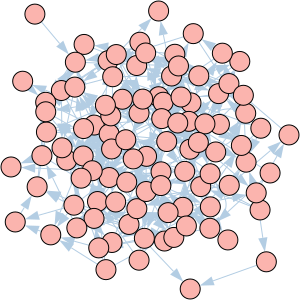

In [ ]:
# Generate Graph
G = Graph.Erdos_Renyi(n=100,m=300,directed=True)

# Plot Graph
G.es["color"], G.vs["color"], G.vs["label"] = "#B3CDE3", "#FBB4AE", ""
plot(G, bbox = (300, 300),margin = 11,layout = G.layout("kk"))

We can now run each of the algorithms to solve for a seed set of size k=10 and 1000 Monte Carlo simulations. It is possible to see that both approaches yield identical seed sets.

In [ ]:
# Run algorithms
celf_output = celf(G,10,p = 0.1,mc = 1000)
greedy_output = greedy(G,10,p = 0.1,mc = 1000)

# Print resulting seed sets
print("celf output:   " + str(celf_output[0]))
print("greedy output: " + str(greedy_output[0]))

100%|██████████| 10/10 [04:10<00:00, 25.04s/it]

celf output:   [68, 81, 9, 69, 64, 88, 86, 55, 93, 30]
greedy output: [68, 81, 9, 69, 64, 88, 86, 55, 93, 30]


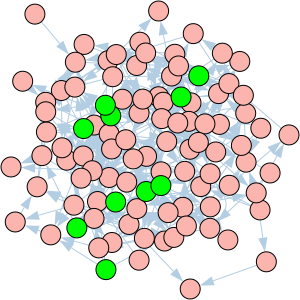

In [ ]:
# Plot Graph with seed set nodes
for node in celf_output[0]:
    G.vs[node]["color"] = "green"
plot(G, bbox = (300, 300),margin = 11,layout = G.layout("kk"))

We can also compare the speed of each algorithm. The plot below shows that the computation time of Greedy is larger than CELF for all seed set sizes greater than 1 and the difference in computational times grows exponenitally with the size of the seed set. This is due to the fact that Greedy must compute the spread of N−i−1 nodes in iteration i whereas CELF generally performs far fewer spread computations after the first iteration.

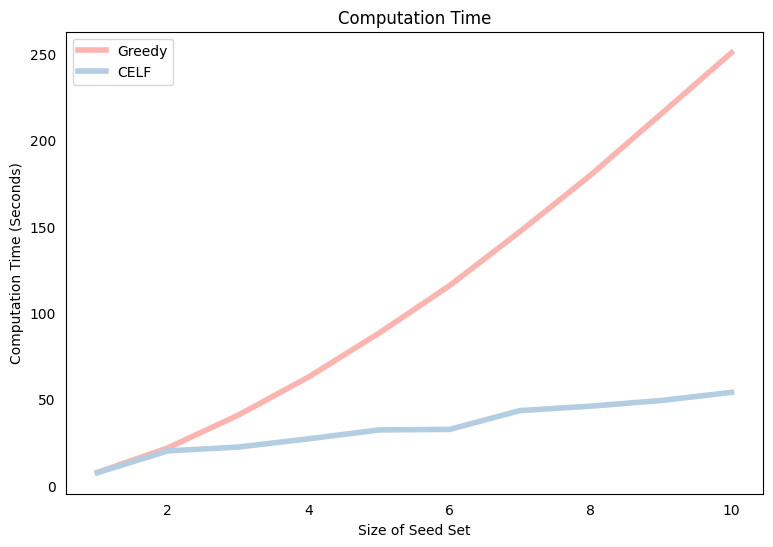

In [ ]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output[2])+1),greedy_output[2],label="Greedy",color="#FBB4AE")
plt.plot(range(1,len(celf_output[2])+1),celf_output[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);

We can get some further insight into the superior computational efficiency of CELF by observing how many “node lookups” it had to perform during each of the 10 rounds. The list stored in `celf_output[3]` shows that the first round iterated over all 100 nodes of the network. This is identical to Greedy which is why the graph above shows that the running time is equivalent for k=1. However, for subsequent iterations, there are far fewer spread computations because the marginal sprea of a node in a previous iteration is a good indicator for its marginal spread in a future iteration. Note the relationship between the values below and the corresponding computation time presented in the graph above. There is a visible jump in the blue line for higher values of the “node lookups”.

In [ ]:
print(celf_output[3])

[100, 88, 10, 19, 19, 1, 33, 8, 8, 12]


Finally, we plot the resulting expected spread for each seed set size. Both methods yield the same expected spread, which is simply a function of the identical seed sets, but note that the function is concave, which is consistent with the submodularity of the spread function.

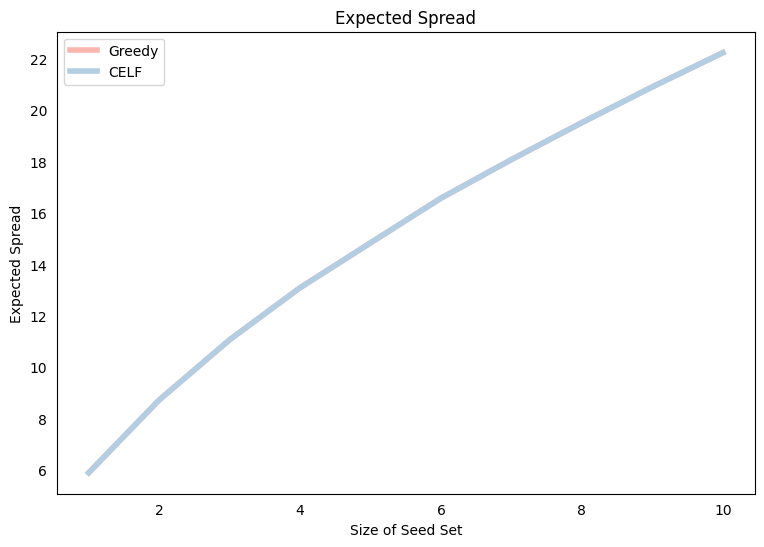

In [ ]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(greedy_output[1])+1),greedy_output[1],label="Greedy",color="#FBB4AE")
plt.plot(range(1,len(celf_output[1])+1),celf_output[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2);

## Real-world SNAP dataset: Facebook social circles

This dataset consists of 'circles' (or 'friends lists') from Facebook. Facebook data was collected from survey participants using the Facebook app. The dataset includes node features (profiles), circles, and ego networks.

Data available on: https://snap.stanford.edu/data/ego-Facebook.html


**Dataset statistics**:
- Nodes: $4039$
- Edges: $88234$
- Average clustering coefficient: $0.6055$
- Number of triangles: $1612010$
- Fraction of closed triangles: $0.2647$
- Diameter: $8$

For this step, we begin by defining a function that loads the Facebook edge-list file into an adjacency matrix.

In [ ]:
def load_graph_im(edgelist_filename, delimiter='\t', comment='#'):
    """
    Load an undirected and unweighted graph from an edge-list file.
    :param edgelist_filename: string or unicode
        Path to the edge-list file.
        Id of nodes are assumed to be non-negative integers.
    :param delimiter: str, default '\t'
    :param comment: str, default '#'
    :return: Compressed Sparse Row Matrix
        Adjacency matrix of the graph
    """
    edge_df = pd.read_csv(edgelist_filename, delim_whitespace=True, names=["src", "dst"])
    edge_list = edge_df.values
    n_nodes = int(np.max(edge_list) + 1)
    adj_matrix = sparse.coo_matrix((np.ones(edge_list.shape[0]), (edge_list[:, 0], edge_list[:, 1])),
                                   shape=tuple([n_nodes, n_nodes]),
                                   dtype=edge_list.dtype)
    adj_matrix = adj_matrix.tocsr()
    adj_matrix = adj_matrix + adj_matrix.T
    return adj_matrix

In [ ]:
print("Load Facebook data...")
adj_matrix_snap = load_graph_im("/data/facebook_combined.txt")
print("Loading successful!")

Load Facebook data...
Loading successful!


We then convert the sparse adjacency matrix into a graph object.

In [ ]:
dense_adj_matrix_snap = adj_matrix_snap.toarray()
G = Graph.Adjacency((dense_adj_matrix_snap > 0).tolist())

Finally, we can run the algorithm and compare the performance of the different IM methods in the real-world dataset. Since we are dealing with a much bigger graph than the synthetic one, we will only run 1 Montecarlo simulation since it would take a lot of time to run all the algorithms, and we are not interested in getting the best result but rather in comparing the different methods.

In [ ]:
# Run algorithms
celf_output = celf(G,10,p = 0.1,mc = 1)
greedy_output = greedy(G,10,p = 0.1,mc = 1)

# Print resulting seed sets
print("celf output:   " + str(celf_output[0]))
print("greedy output: " + str(greedy_output[0]))

100%|██████████| 10/10 [40:32<00:00, 243.21s/it]

celf output:   [1085, 0, 686, 107, 1912, 3980, 137, 634, 348, 3628]
greedy output: [1085, 0, 686, 107, 1912, 3980, 19, 577, 348, 3628]


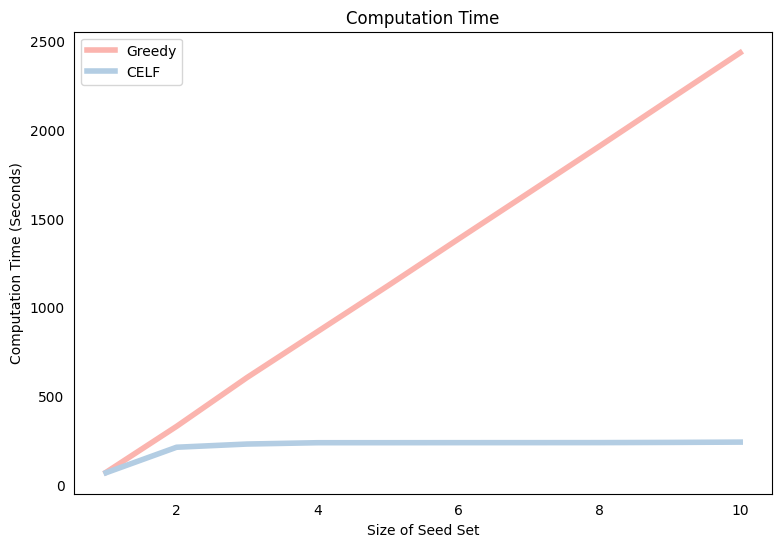

In [ ]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output[2])+1),greedy_output[2],label="Greedy",color="#FBB4AE")
plt.plot(range(1,len(celf_output[2])+1),celf_output[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);

In [ ]:
print(celf_output[3])

[4039, 2357, 265, 115, 1, 4, 1, 3, 18, 27]


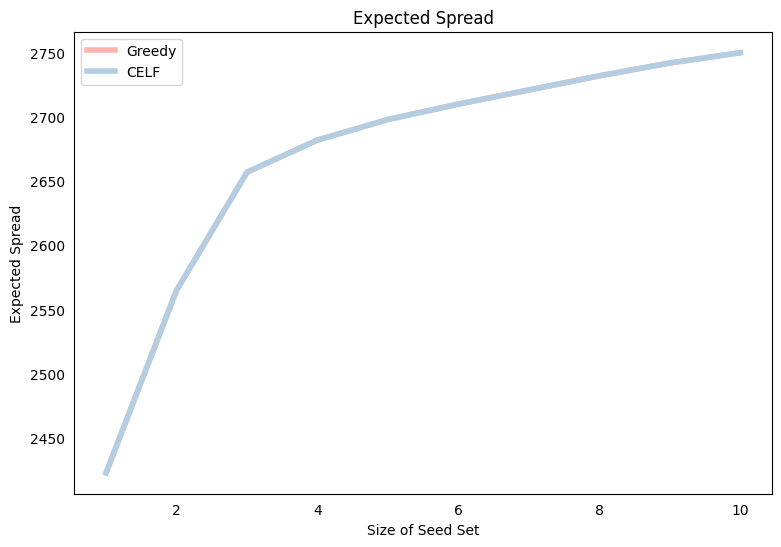

In [ ]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(greedy_output[1])+1),greedy_output[1],label="Greedy",color="#FBB4AE")
plt.plot(range(1,len(celf_output[1])+1),celf_output[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2);

Based on the results above, it is possible to see that both approaches yield the same seed set and spreads, just like previosuly observed in the synthetic dataset. The computational time for the greedy algorithm was again higher than the celf approach for all seed set sizes greater than 1. Unfortunately, differently from the synthetic dataset, the graph representing the Facebook dataset cannot be visualized due to its high number of nodes.

## Learning-based Approach

The learning-based approach that we are going to use to solve the Influence Maximization problem is the framework explained in the paper that was presented in class about graph embeddings. In the paper, named "Deep Graph Representation Learning and Optimization for Influence Maximization", the authors proposed a framework called DeepIM [7].

DeepIM implements a strategy that embeds the initial discrete optimization domain of the problem into a larger continuous space. The framework then learns the latent representation of the seed sets by retaining their expressiveness and directly optimizing in the continuous space to reduce the problem's hardness. In additon, a new learning-based diffusion model is designed to characterize the underlying diffusion dynamics of the problem. Finally, a generic seed set inference is developed to directly optimize and generate set embeddings under a uniform budget constraint. The framework architecture can be seen below:

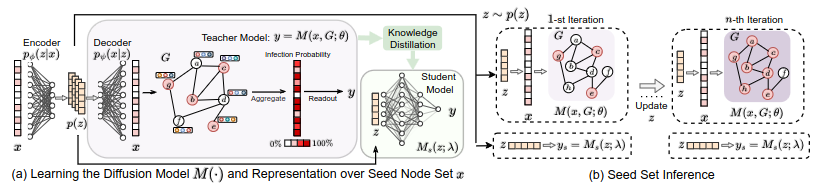

In [ ]:
#@title .
img = Image.open('/img/pipeline.png')
display(img)

The architecture consists of two parts:

a) The autoencoder is leveraged to learn and compress the latent distribution of seed node sets into lower dimension $p(z)$. The lower dimension $p(z)$ is then leveraged to learn an end-to-end and monotonic diffusion model $M(x,G;\theta)$ for accurately predicting the influence spread. In addition, a knowledge distillation module is employed to train a lightweight student model in order to retain efficiency in predicting the influence spread.

b) The seed set inference scheme iteratively optimizes the objective function by updating the latent variable $z$ initially sampled from the learned $p(z)$, to maximize the influence spread.

So let's jump to the implementation of the algorithm. We first begin by setting up the environment for running the task. Then, we set the parameters of the algorithm, which are:

1. **Dataset**: The Jazz dataset was collected in 2003 and it is a collaboration network between Jazz musicians. Each node is a Jazz musician and an edge denotes that two musicians have played together in a band.

Data available on: http://konect.cc/networks/arenas-jazz/

**Dataset statistics**:
- Nodes: $198$
- Volume: $2742$
- Average clustering coefficient: $0.520259$
- Number of triangles: $17899$
- Diameter: $6$

The authors of the framework tested their algorithm not only on this dataset, but also on another real-world datasets such as Cora-ML, Network Science, and Digg. The choice of the Jazz dataset for this notebook is only for simplification matters, since such dataset is smaller than the other real-world datasets, which turns the computation lighter. In addition, the authors of the paper also conducted a visualization comparison using the Jazz dataset, which is shown at the end of this notebook.

2. **Diffusion model**: Determines the diffusion pattern to compute the final influence spread $y$, which then serves as the training set of the algorithm. The possible options are IC (Independent Cascade), LT (Linear Threshold) and SIS (Susceptible-Infectious-Susceptible).

3. **Seed rate**: The inital proportion of nodes (in %) in the network that are initially active.

4. **Mode**: Whether or not a budget constraint is to be considered. In this paper, the budget constraint is explicitly defined as the node degree.

In [ ]:
print('Is GPU available? {}\n'.format(torch.cuda.is_available()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CUDA_LAUNCH_BLOCKING=1

dataset = 'jazz'          # one of ['jazz', 'cora_ml', 'power_grid', 'netscience', 'random5']
diffusion_model = 'IC'    # one of ['IC', 'LT', 'SIS']
seed_rate = 10            # one of [1, 5, 10, 20]
mode = 'normal'           # one of ['Normal', 'Budget Constraint']

Is GPU available? False



Next, we define four functions to be used throughout the pipeline.

`normalize_adj` is designed to row-normalize a sparse matrix, which is an important step for GNN-based algorithms. The process ensures that each row of the matrix sums to one, adjusting the influence of nodes in the graph based on their connectivity.

`sampling` is designed to perform sampling based on diffusion counts in the dataset.

`loss_all` calculates the combined loss for the model (autoencoding + prediction component).

`loss_inverse` calculates the combined loss consisting of a prediction loss and a regularization term.

In [ ]:
def normalize_adj(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
    return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)

def sampling(inverse_pairs):
    diffusion_count = []
    for i, pair in enumerate(inverse_pairs):
        diffusion_count.append(pair[:, 1].sum())
    diffusion_count = torch.Tensor(diffusion_count)
    top_k = diffusion_count.topk(int(0.1*inverse_pairs.shape[0])).indices
    return top_k

def loss_all(x, x_hat, y, y_hat):
    reproduction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    forward_loss = F.mse_loss(y_hat, y, reduction='sum')
    return reproduction_loss+forward_loss, reproduction_loss, forward_loss

def loss_inverse(y_true, y_hat, x_hat):
    forward_loss = F.mse_loss(y_hat, y_true)
    L0_loss = torch.sum(torch.abs(x_hat))/x_hat.shape[1]
    return forward_loss+L0_loss, L0_loss

Then we perform some operations on the graph structure. We first load the graph structure from the chosen dataset, process its corresponding adjacency matrix, and finally convert the normalized adjacency matrix to a PyTorch tensor.

In [ ]:
with open('/DeepIM/data/' + dataset + '_mean_' + diffusion_model + str(10*seed_rate) + '.SG', 'rb') as f:
    graph = pickle.load(f)

adj, inverse_pairs = graph['adj'], graph['inverse_pairs']


adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
adj = normalize_adj(adj + sp.eye(adj.shape[0]))
adj = torch.Tensor(adj.toarray()).to_sparse()

<ipython-input-25-162325edb496>:2: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  graph = pickle.load(f)


We also need to the define the hyper parameters for the model, which are notably the bach size, the dimension of the hidden layers, and the dimension of the latent space for the autoencoders.

In [ ]:
batch_size = 16
hidden_dim = 1024
latent_dim = 512

Then we set up the training and testing environment for the model within a PyTorch framework. Data is splitted between training and testing sets, and DataLoader objects are created for both of those sets. For the DeepIM framework, the 2-layer GAT-structured diffusion estimation model that each layer contains 4 attention heads and the dimension of each attention channel is 64. Both encoder and decoder are symmetric 4-layer MLP with hidden size 512, 1024, 1024, and 1024 for each layer, respectively. The Adam optimizer was configured with learning rate 1e-4 for optimizing both the VAE model and the GAT model. Finally, the model is set to training mode.

In [ ]:
train_set, test_set = torch.utils.data.random_split(inverse_pairs,
                                                    [len(inverse_pairs)-batch_size,
                                                     batch_size])

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader  = DataLoader(dataset=test_set,  batch_size=1, shuffle=False)

encoder = Encoder(input_dim= inverse_pairs.shape[1],
                  hidden_dim=hidden_dim,
                  latent_dim=latent_dim)

decoder = Decoder(input_dim=latent_dim,
                  latent_dim=latent_dim,
                  hidden_dim=hidden_dim,
                  output_dim=inverse_pairs.shape[1])

vae_model = VAEModel(Encoder=encoder, Decoder=decoder).to(device)

forward_model = SpGAT(nfeat=1,
                nhid=64,
                nclass=1,
                dropout=0.2,
                nheads=4,
                alpha=0.2)

optimizer = Adam([{'params': vae_model.parameters()}, {'params': forward_model.parameters()}],
                 lr=1e-4)

adj = adj.to(device)
forward_model = forward_model.to(device)
forward_model.train()

SpGAT(
  (attention_0): SpGraphAttentionLayer (1 -> 64)
  (attention_1): SpGraphAttentionLayer (1 -> 64)
  (attention_2): SpGraphAttentionLayer (1 -> 64)
  (attention_3): SpGraphAttentionLayer (1 -> 64)
  (attention1_0): SpGraphAttentionLayer (256 -> 64)
  (attention1_1): SpGraphAttentionLayer (256 -> 64)
  (attention1_2): SpGraphAttentionLayer (256 -> 64)
  (attention1_3): SpGraphAttentionLayer (256 -> 64)
  (out_att): SpGraphAttentionLayer (256 -> 1)
)

Then we proceed to the training loop.

In [ ]:
for epoch in range(100):
    begin = time.time()
    total_overall = 0
    forward_loss = 0
    reproduction_loss = 0
    precision_for = 0
    recall_for = 0
    precision_re = 0
    recall_re = 0

    for batch_idx, data_pair in enumerate(train_loader):

        x = data_pair[:, :, 0].float().to(device)
        y = data_pair[:, :, 1].float().to(device)
        optimizer.zero_grad()

        y_true = y.cpu().detach().numpy()
        x_true = x.cpu().detach().numpy()

        loss = 0
        for i, x_i in enumerate(x):

            y_i = y[i]

            x_hat = vae_model(x_i.unsqueeze(0))
            y_hat = forward_model(x_hat.squeeze(0).unsqueeze(-1), adj)
            total, re, forw = loss_all(x_i.unsqueeze(0), x_hat, y_i, y_hat.squeeze(-1))

            loss += total

            x_pred = x_hat.cpu().detach().numpy()
            x_pred[x_pred>0.01] = 1
            x_pred[x_pred!=1] = 0

            precision_re += precision_score(x_true[i], x_pred[0], zero_division=0)
            recall_re += recall_score(x_true[i], x_pred[0], zero_division=0)


        total_overall += loss.item()
        loss = loss/x.size(0)

        loss.backward()
        optimizer.step()
        for p in forward_model.parameters():
            p.data.clamp_(min=0)

    end = time.time()
    print("Epoch: {}".format(epoch+1),
          "\tTotal: {:.4f}".format(total_overall / len(train_set)),
          "\tReconstruction Precision: {:.4f}".format(precision_re / len(train_set)),
          "\tReconstruction Recall: {:.4f}".format(recall_re / len(train_set)),
          "\tTime: {:.4f}".format(end - begin)
         )

Epoch: 1 	Total: 171.5351 	Reconstruction Precision: 0.0960 	Reconstruction Recall: 1.0000 	Time: 4.7747
Epoch: 2 	Total: 160.9442 	Reconstruction Precision: 0.0960 	Reconstruction Recall: 1.0000 	Time: 4.3917
Epoch: 3 	Total: 160.6132 	Reconstruction Precision: 0.0960 	Reconstruction Recall: 1.0000 	Time: 2.6672
Epoch: 4 	Total: 159.8700 	Reconstruction Precision: 0.0960 	Reconstruction Recall: 1.0000 	Time: 2.1791
Epoch: 5 	Total: 160.0530 	Reconstruction Precision: 0.0960 	Reconstruction Recall: 1.0000 	Time: 2.6070
Epoch: 6 	Total: 159.3589 	Reconstruction Precision: 0.0960 	Reconstruction Recall: 1.0000 	Time: 2.1394
Epoch: 7 	Total: 159.4662 	Reconstruction Precision: 0.0960 	Reconstruction Recall: 1.0000 	Time: 2.1890
Epoch: 8 	Total: 158.9091 	Reconstruction Precision: 0.0960 	Reconstruction Recall: 1.0000 	Time: 2.1394
Epoch: 9 	Total: 158.6287 	Reconstruction Precision: 0.0960 	Reconstruction Recall: 1.0000 	Time: 2.1311
Epoch: 10 	Total: 157.7084 	Reconstruction Precision: 0

We also freeze the VAE and forward models for training.

In [ ]:
for param in vae_model.parameters():
    param.requires_grad = False

for param in forward_model.parameters():
    param.requires_grad = False

encoder = vae_model.Encoder
decoder = vae_model.Decoder

We perform again the same operations on the graph structure as we did before.

In [ ]:
with open('/DeepIM/data/' + dataset + '_mean_' + diffusion_model + str(10*seed_rate) + '.SG', 'rb') as f:
    graph = pickle.load(f)

adj, inverse_pairs = graph['adj'], graph['inverse_pairs']

adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
adj = normalize_adj(adj + sp.eye(adj.shape[0]))
adj = torch.Tensor(adj.toarray()).to_sparse().to(device)

<ipython-input-30-96a591e9eb2d>:2: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  graph = pickle.load(f)


Finally, a top-k sampling method is used to select seeds from `inverse_pairs`, and an optimization process is then performed on a latent representation `z_hat`. Initially, `z_hat` is computed as the average encoding of the selected seeds by the encoder. The goal is to optimize `z_hat` such that the decoded `x_hat` and the subsequent prediction `y_hat` by the forward_model closely match a target condition (`y_true`). The optimization uses an Adam optimizer with a learning rate of 1e-4 and iterates 300 times. In each iteration, `x_hat` is generated by decoding `z_hat`, `y_hat` is predicted using `x_hat` and the adjacency matrix adj, and a binary condition is applied to `y_hat` to obtain y. The loss function `loss_inverse` calculates the total loss and an L0 regularization term from `y_true`, `y_hat`, and `x_hat`, which is then backpropagated to update `z_hat`. The process aims to refine `z_hat` to produce an `x_hat` that, when used by the forward_model, results in a `y_hat` matching the desired `y_true`. After optimization, the top-k values of `x_hat` are selected as seeds, with their indices extracted and converted to a NumPy array, indicating the final seed selection.

In [ ]:
topk_seed = sampling(inverse_pairs)

z_hat = 0
for i in topk_seed:
    z_hat += encoder(inverse_pairs[i, :, 0].unsqueeze(0).to(device))

z_hat = z_hat/len(topk_seed)
seed_num = int(x_hat.sum().item())
y_true = torch.ones(x_hat.shape).to(device)

z_hat = z_hat.detach()
z_hat.requires_grad = True
z_optimizer = Adam([z_hat], lr=1e-4)

for i in range(300):

    x_hat = decoder(z_hat)

    y_hat = forward_model(x_hat.squeeze(0).unsqueeze(-1), adj)

    y = torch.where(y_hat > 0.05, 1, 0)

    loss, L0 = loss_inverse(y_true, y_hat, x_hat)

    loss.backward()
    z_optimizer.step()

    print('Iteration: {}'.format(i+1),
          '\t Total Loss:{:.5f}'.format(loss.item())
         )

top_k = x_hat.topk(seed_num)
seed = top_k.indices[0].cpu().detach().numpy()

<ipython-input-19-7400a8a7d212>:23: UserWarning: Using a target size (torch.Size([1, 198])) that is different to the input size (torch.Size([198, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  forward_loss = F.mse_loss(y_hat, y_true)


Iteration: 1 	 Total Loss:0.97502
Iteration: 2 	 Total Loss:0.96779
Iteration: 3 	 Total Loss:0.91866
Iteration: 4 	 Total Loss:0.94174
Iteration: 5 	 Total Loss:0.92958
Iteration: 6 	 Total Loss:0.90451
Iteration: 7 	 Total Loss:0.89903
Iteration: 8 	 Total Loss:0.95612
Iteration: 9 	 Total Loss:0.97296
Iteration: 10 	 Total Loss:0.96852
Iteration: 11 	 Total Loss:0.92550
Iteration: 12 	 Total Loss:0.97219
Iteration: 13 	 Total Loss:0.93418
Iteration: 14 	 Total Loss:0.94511
Iteration: 15 	 Total Loss:0.96091
Iteration: 16 	 Total Loss:0.91391
Iteration: 17 	 Total Loss:0.95239
Iteration: 18 	 Total Loss:0.96160
Iteration: 19 	 Total Loss:0.94366
Iteration: 20 	 Total Loss:0.96965
Iteration: 21 	 Total Loss:0.92870
Iteration: 22 	 Total Loss:0.94304
Iteration: 23 	 Total Loss:0.94713
Iteration: 24 	 Total Loss:0.91096
Iteration: 25 	 Total Loss:0.95504
Iteration: 26 	 Total Loss:0.95492
Iteration: 27 	 Total Loss:0.95475
Iteration: 28 	 Total Loss:0.91879
Iteration: 29 	 Total Loss:0.

We can now evaluate the diffusion process of the graph based on the selected seed set. After loading the graph structure, we perform the same operations as we did before to get the adjancency matrix and the inversed pairs.

The ifluence of the diffusion process is calculated using the function `diffusion_evaluation`, which simulates the diffusion process on the graph using the previously selected seeds.

In [ ]:
with open('/DeepIM/data/' + dataset + '_mean_' + diffusion_model + str(10*seed_rate) + '.SG', 'rb') as f:
    graph = pickle.load(f)

adj, inverse_pairs = graph['adj'], graph['inverse_pairs']

influence = diffusion_evaluation(adj, seed, diffusion = diffusion_model)
print('Number of influenced nodes: {}'.format(influence))

Number of influenced nodes: 198.0


<ipython-input-33-3da40033376a>:2: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  graph = pickle.load(f)


The output corresponds to the number of the influenced nodes until the diffusion process stops. It is possible to visualize the influence spread on this graph below. Such visualization was created by the authors and it depicts the graph corresponding to the Jazz dataset with 10% of the nodes selected to be in the seed set. The size of nodes is determined by the node degree, and the color on nodes
determines the infection status: purple means the node is in seed set, pink means the node was infected, and grey means the node was not infected.

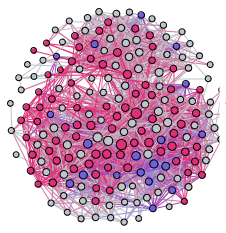

In [ ]:
#@title .
img = Image.open('/img/jazz.png')
display(img)

# References

[1] Blondel, V. D., Guillaume, J.-L., Lambiotte, R., & Lefebvre, E. (2008). **Fast unfolding of communities in large networks. Journal of Statistical Mechanics: Theory and Experiment**, 2008(10), P10008. [Access it.](https://arxiv.org/pdf/0803.0476.pdf)

[2] Girvan, M., & Newman, M. E. J. (2002). **Community structure in social and biological networks**. Proceedings of the National Academy of Sciences, 99(12), 7821-7826. [Access it.](https://doi.org/10.1073/pnas.122653799)

[3] Alexandre Hollocou, Thomas Bonald, Marc Lelarge. **Multiple Local Community Detection**. IFIP WG
7.3 Performance 2017 conference - International Symposium on Computer Performance, Modeling,
Measurements and Evaluation 2017, Nov 2017, New York City, United States. ffhal-01625444. [Access it.](https://hal.science/hal-01625444v1/document)

[4] Hautahi Kingi. **Influence Maximization in Python - Greedy vs CELF**. [Access it.](https://hautahi.com/im_greedycelf)

[5] David Kempe, Jon Kleinberg, and Éva Tardos. 2003. **Maximizing the spread of influence through a social network**. In Proceedings of the ninth ACM SIGKDD international conference on Knowledge discovery and data mining (KDD '03). Association for Computing Machinery, New York, NY, USA, 137–146. [Access it.](https://www.cs.cornell.edu/home/kleinber/kdd03-inf.pdf)

[6] Jure Leskovec, Andreas Krause, Carlos Guestrin, Christos Faloutsos, Jeanne VanBriesen, and Natalie Glance. 2007. **Cost-effective outbreak detection in networks**. In Proceedings of the 13th ACM SIGKDD international conference on Knowledge discovery and data mining (KDD '07). Association for Computing Machinery, New York, NY, USA, 420–429. [Access it.](https://www.cs.cmu.edu/~jure/pubs/detect-kdd07.pdf)

[7] Chen Ling, Junji Jiang, Junxiang Wang, My T. Thai, Lukas Xue, James Song, Meikang Qiu, and Liang Zhao. 2023. **Deep graph representation learning and optimization for influence maximization**. In Proceedings of the 40th International Conference on Machine Learning (ICML'23), Vol. 202. JMLR.org, Article 880, 21350–21361. [Access it.](https://arxiv.org/pdf/2305.02200.pdf)